In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import esda as es
import json
import libpysal as ps
from esda.moran import Moran
import geopandas as gpd
from shapely.geometry import Point

## Load data

In [4]:
plt.style.use('ggplot')
# load the feature category dictionary
with open('feature_category_dict.json') as f:
	fcmap = json.load(f)

data=pd.read_csv('combined_data_with_loc.csv')
data.head()

,Community Name,Region,Map reference,Grid reference,Location,Population Density,Travel time to GPO (minutes),Distance to GPO (km),LGA,Primary Care Partnership,...,Travel time to nearest public hospital with emergency department,Distance to nearest public hospital with emergency department,Presentations to emergency departments due to injury,"Presentations to emergency departments due to injury, %",Category 4 & 5 emergency department presentations,"Category 4 & 5 emergency department presentations, %",geo_lat,geo_lon,cart_x,cart_y
0,Ascot Vale,Northern and Western Metropolitan,4,B3,6km NW of Melbourne,3758.623596,9.360142,6.958742,Moonee Valley (C),Inner North West Primary Care Partnership,...,6.630953,4.993841,679.257076,20.502456,1864.918123,56.290032,-37.775606,144.914871,-4.230377,4.251470
1,Braybrook,Northern and Western Metropolitan,4,A3,10km WNW of Melbourne,2025.468296,15.131666,11.595888,Maribyrnong (C),"HealthWest (b): Hobson's Bay, Maribyrnong, Wyn...",...,12.824977,10.161988,543.631989,20.647263,1683.966712,63.957428,-37.779315,144.858155,-9.212552,3.839001
2,Craigieburn,Northern and Western Metropolitan,2,A3,27km N of Melbourne,1034.970870,31.994666,43.100287,Hume (C),Hume-Whittlesea Primary Care Partnership,...,11.570855,15.213189,2044.424399,20.618005,5102.134434,51.454988,-37.570576,144.963028,0.000000,27.049690
3,Croydon,Eastern Metropolitan,2,B4,28km E of Melbourne,1730.064830,28.992647,34.071323,Maroondah (C),Outer East Primary Care Partnership,...,5.093285,3.601752,1754.954941,28.537825,3062.182462,49.795026,-37.813411,145.281013,27.933349,0.047723
4,Fawkner,Northern and Western Metropolitan,4,C1,12km N of Melbourne,2619.120089,17.405267,13.047142,Moreland (C),Inner North West Primary Care Partnership,...,11.510757,12.004044,680.401318,17.909865,1942.874353,51.141315,-37.705724,144.963028,0.000000,12.021947


## Visualize Suburbs

$(x,y)$ locations based on the compass bearing and the distance from Melbourne GPO, with GPO co-ordinate as $(0,0)$

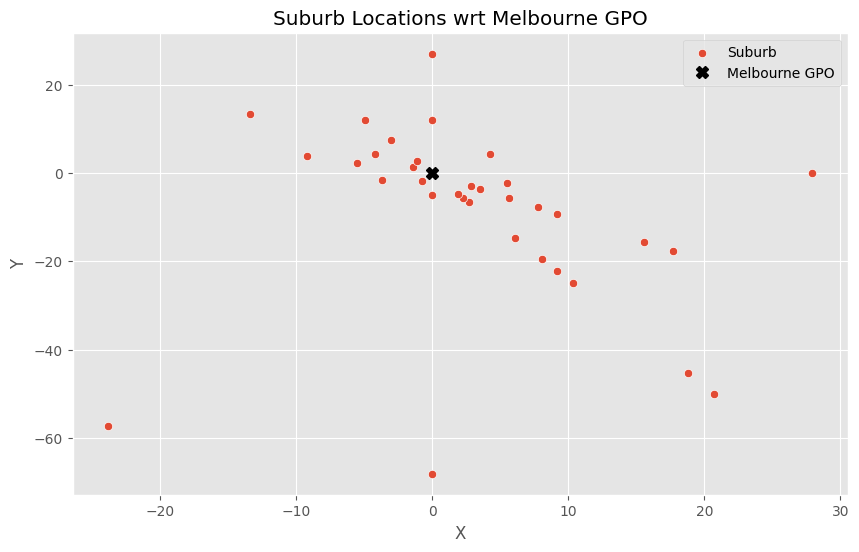

In [17]:
# plot boxes around the points
plt.figure(figsize=(10, 6))
sns.scatterplot(x='cart_x', y='cart_y', data=data)
plt.xlabel('X')
plt.ylabel('Y')
# show origin
plt.plot(0, 0, 'X', markersize=9, color='black')
plt.legend(['Suburb', 'Melbourne GPO'])
plt.title('Suburb Locations wrt Melbourne GPO')
plt.show()

## Avg distances of the neighbouring suburbs

In [113]:
from sklearn.neighbors import NearestNeighbors
import scipy.stats as stats

class nnStats:
	def __init__(self, n_nbd):
		self.n_nbd=n_nbd
	def get_dist_mean(self):
		nn=NearestNeighbors(n_neighbors=self.n_nbd,metric='euclidean')
		nn.fit(data[['cart_x', 'cart_y']])
		distances, indices = nn.kneighbors(data[['cart_x', 'cart_y']])
		self.avg_dist=float(np.mean(distances[:, -1]))
		self.median_dist=float(np.median(distances[:, -1]))
		distances = distances[:, 1:].mean(axis=1)
		return distances
	
	def get_plot_avg_dist(self):
		dist=self.get_dist_mean()
		plt.figure(figsize=(5, 5))
		sns.displot(dist, kde=True)
		plt.axvline(self.avg_dist, color='red', linestyle='--', label='Mean distance')
		plt.axvline(self.median_dist, color='blue', linestyle='--', label='Median distance')
		plt.xlabel('Distance')
		plt.ylabel('Frequency')
		plt.title(f'Average distance of all the neighbours up to: {self.n_nbd}')
		plt.legend()
		plt.show()
		return None
    

In [114]:
for i in range(2, 6):
	dist_details=nnStats(i)
	dist_details.get_dist_mean()
	print(f'(Avg, Median) distances of all the neighbours up to {i}: {(dist_details.avg_dist, dist_details.median_dist)}')

(Avg, Median) distances of all the neighbours up to 2: (5.245844868152378, 3.002145038830941)
(Avg, Median) distances of all the neighbours up to 3: (8.212108297752518, 5.000021947800075)
(Avg, Median) distances of all the neighbours up to 4: (9.474117173901222, 6.196951246827995)
(Avg, Median) distances of all the neighbours up to 5: (10.573740404368039, 7.138554022936674)


<Figure size 500x500 with 0 Axes>

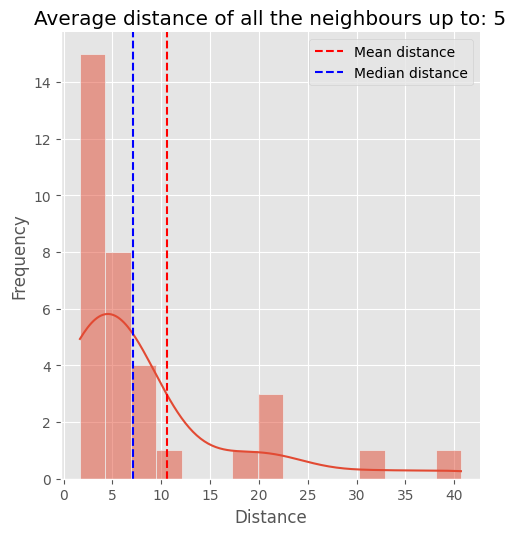

In [108]:
dist_details.get_plot_avg_dist()

## Test out autocorrelation for an example feature

Let's test `Population Density`

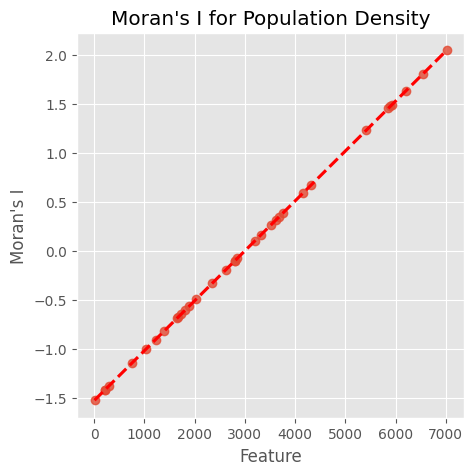

Moran's I: 0.6716484992594537
Moran's Expected I: -0.030303030303030304
Moran's I p-value: 0.001


In [124]:
from geopandas import GeoDataFrame
# choose k=4
k=4

# select the feature
feature='Population Density'

gdf=gpd.GeoDataFrame(data, geometry=gpd.points_from_xy(data['cart_x'], data['cart_y']))

# create a spatial weights matrix
w=ps.weights.KNN.from_dataframe(gdf, k=k)

# create a Moran object
moran=Moran(data[feature], w)

# plot the Moran scatter plot
plt.figure(figsize=(5, 5))
sns.regplot(x=data[feature], y=moran.z, line_kws={'color':'red', 'linestyle':'--'})
plt.xlabel('Feature')
plt.ylabel('Moran\'s I')
plt.title(f'Moran\'s I for {feature}')
plt.show()

print('Moran\'s I:', moran.I)
print('Moran\'s Expected I:', moran.EI)
print('Moran\'s I p-value:', moran.p_sim)


In [126]:
w.full()

(array([[0.  , 0.  , 0.  , ..., 0.  , 0.  , 0.  ],
        [0.25, 0.  , 0.  , ..., 0.  , 0.  , 0.  ],
        [0.  , 0.  , 0.  , ..., 0.  , 0.  , 0.  ],
        ...,
        [0.  , 0.  , 0.  , ..., 0.  , 0.25, 0.  ],
        [0.  , 0.  , 0.  , ..., 0.  , 0.  , 0.  ],
        [0.  , 0.  , 0.  , ..., 0.  , 0.  , 0.  ]]),
 [0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24,
  25,
  26,
  27,
  28,
  29,
  30,
  31,
  32,
  33])